#Paquetes necesarios

In [1]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

El mundo real es muy variado, las imágenes no siempre se capturan con unas condiciones de iluminación tan buenas o controladas. Ejemplo con aplicación de variantes de umbralizados ofrecidas por OpenCV.

Umbral escogido  122.0
1
1398
68222
24567


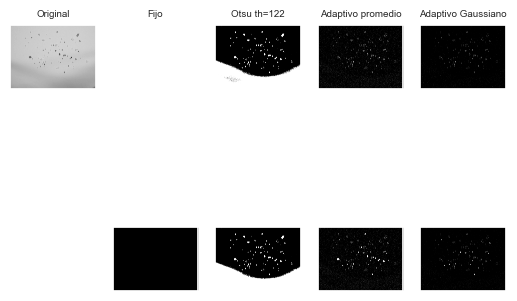

In [9]:
#Carga imagen directamente en grises
imgorig = cv2.imread('uno.JPG', cv2.IMREAD_GRAYSCALE) 

img = cv2.GaussianBlur(imgorig,(5,5),0)

#Umbralizados
ret,imth1 = cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
thotsu,imth2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral escogido ', thotsu)
imth3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
imth4 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
 
titles = ['Original', 'Fijo','Otsu th='+str(int(thotsu)),
            'Adaptivo promedio', 'Adaptivo Gaussiano']
images = [img, imth1, imth2, 255 - imth3, 255 - imth4]
 
for i in range(5):
    plt.subplot(2,5,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i], fontsize=7)
    plt.xticks([]),plt.yticks([])

    #Obtiene únicamente los contornos externos
    if i>0:
        res,imth = cv2.threshold(images[i],120,255,cv2.THRESH_BINARY)
        contornos, hierarchy= cv2.findContours(imth, 
        cv2.RETR_EXTERNAL , 
        cv2.CHAIN_APPROX_SIMPLE)
        print(len(contornos))
        img_cont = np.zeros(img.shape)
        cv2.drawContours(img_cont, contornos, -1, (255,255,255), -1)  
        plt.subplot(2,5,i+6),plt.imshow(img_cont,'gray')
        plt.xticks([]),plt.yticks([])
plt.show()

Clasificación de microplásticos

Text(0.5, 1.0, 'Alquitrán')

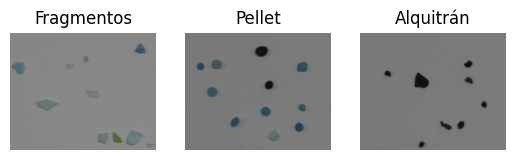

In [3]:
#Cargamos tres subimágenes de cada uno de los tres tipos considerados (el alquitrán no es microplástico)
imgF = cv2.imread('FRA.png') 
imgP = cv2.imread('PEL.png') 
imgT = cv2.imread('TAR.png') 

#Mostramos
plt.subplot(131)
plt.axis("off")
plt.imshow(imgF) 
plt.title('Fragmentos')
plt.subplot(132)
plt.axis("off")
plt.imshow(imgP) 
plt.title('Pellet')
plt.subplot(133)
plt.axis("off")
plt.imshow(imgT) 
plt.title('Alquitrán')

El objetivo de la siguiente tarea, descrita más abajo, es desarrollar tu propio clasificador basado únicamente en heurísticas desde características geométricas y/o de apariencia, para distinguir en las imágenes completas, las partículas de cada tipo, debiendo mostrar la bondad del clasificador haciendo uso de métricas para ello. La siguiente celda obtiene varias métricas para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión. La ejecución de la celda requiere instalar el paquete scikit-learn.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador para las distintas clases conocidas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente.

El siguiente ejemplo, muestra el modo de obtener la matriz de confusión para un hipotético problema con cuatro clases, y valores de anotación (variable y) y predicción (variable y_pred) obtenidos de forma aleatoria.

Anotaciones  [2, 2, 3, 1, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 3, 3, 3, 2, 2, 2, 2, 0, 1, 0, 1, 3, 2, 2, 0, 1, 1, 2, 2, 3, 1, 1, 2, 1, 3, 3, 2, 1, 3, 0, 3, 2, 2, 0, 0, 1, 2, 3, 1, 1, 1, 3, 1, 2, 2, 0, 2, 3, 1, 0, 3, 1, 1, 3, 3, 3, 2, 3, 2, 1, 2, 2, 3, 1, 3, 1, 2, 0, 1, 3, 1, 1, 0, 1, 1, 3, 2, 3, 1, 3, 3]
Predicciones  [0, 3, 2, 2, 1, 1, 0, 0, 2, 0, 0, 2, 3, 3, 1, 2, 0, 2, 2, 0, 1, 0, 3, 0, 1, 2, 2, 3, 0, 0, 2, 0, 1, 2, 0, 1, 2, 3, 2, 3, 2, 3, 2, 0, 0, 3, 3, 0, 0, 3, 0, 3, 0, 1, 3, 1, 1, 3, 2, 3, 0, 0, 3, 0, 3, 0, 2, 0, 0, 2, 3, 0, 1, 0, 2, 0, 0, 0, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 0, 3, 1, 2, 2, 3, 1, 1, 3]
¿Cómo de bien encajan anotación y predicción?
Accuracy (TP/(n))= 0.27
Precision (TP/(TP+FP)) = 0.27435330261136714
Recall (TP/(TP+FN)) = 0.27
F1 Score (2*(precision*recall)/(precision+recall)) = 0.2619224489795918


Text(38.25, 0.5, 'Real/Anotado')

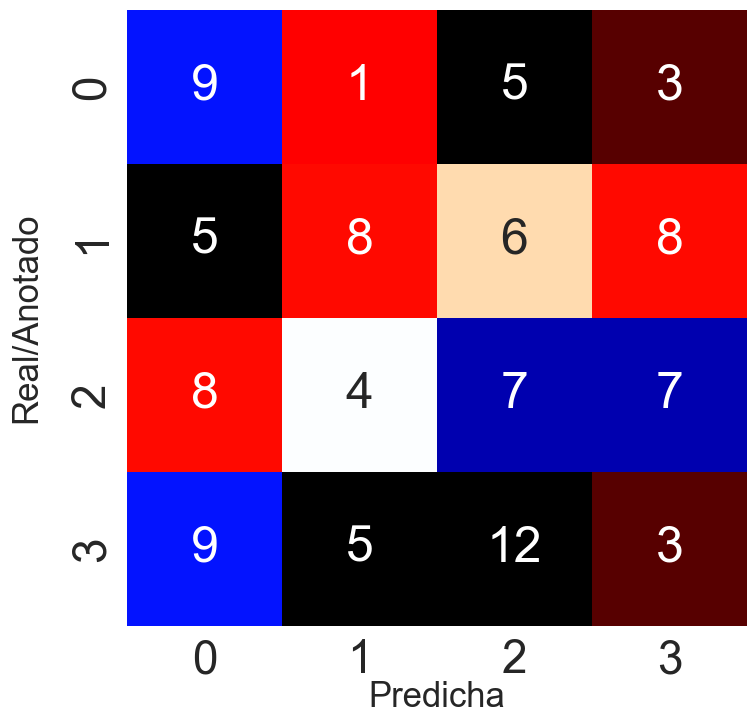

In [7]:

import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


# Numero de muestras
n = 100  
nclases = 4

# A falta de clasificador y conjunto de datos, creamos anotaciones y predicciones de forma aleatoria
# Vector aleatorio con etiquetas anotadas
y = [random.randint(0, nclases - 1) for _ in range(n)]
print('Anotaciones ' , y)

# Vector aleatorio con etiquetas predichas por un supuesto clasificador
y_pred = [random.randint(0, nclases - 1) for _ in range(n)]
print('Predicciones ' , y_pred)

print('¿Cómo de bien encajan anotación y predicción?')

#Cálculo de métricas
accuracy = accuracy_score(y, y_pred)
#Para más de una clase se define la forma de promediar
precision = precision_score(y, y_pred,average='weighted')
recall = recall_score(y, y_pred,average='weighted')
f1score = f1_score(y, y_pred,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Real/Anotado", labelpad=20, fontdict=label_font)

TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

Accuracy: 0.39
Precision: 1.00
Recall: 0.39
F1 Score: 0.56
------------------------------------------
Accuracy: 0.81
Precision: 1.00
Recall: 0.81
F1 Score: 0.90
------------------------------------------
Accuracy: 0.67
Precision: 1.00
Recall: 0.67
F1 Score: 0.80
------------------------------------------


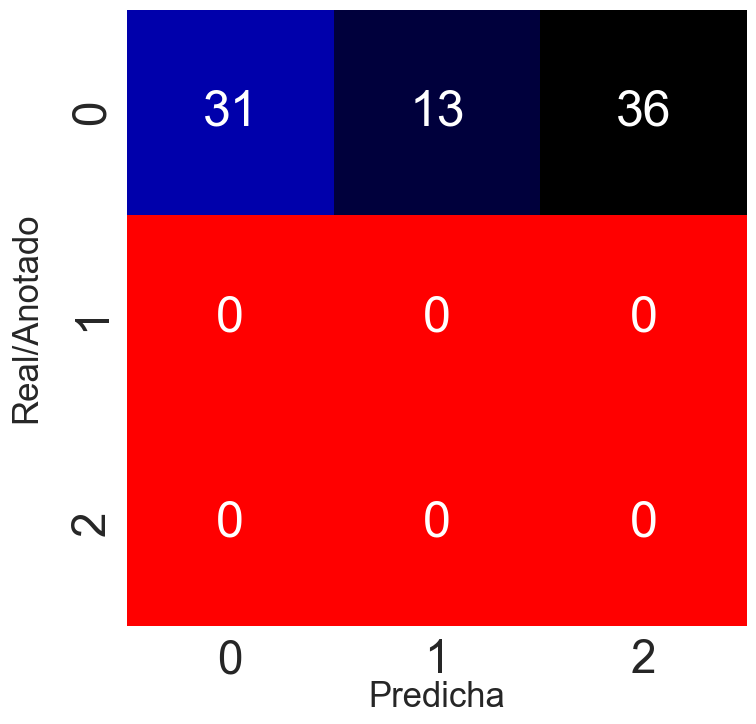

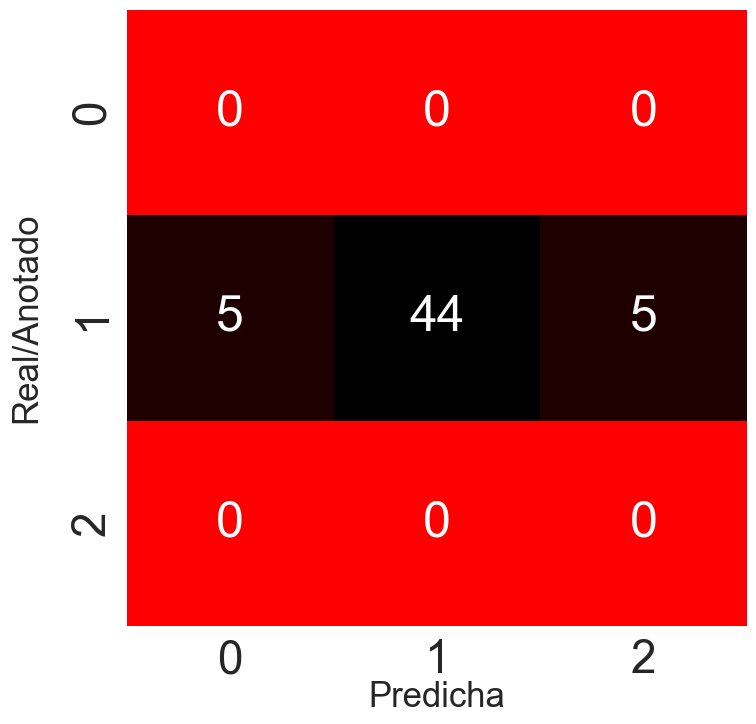

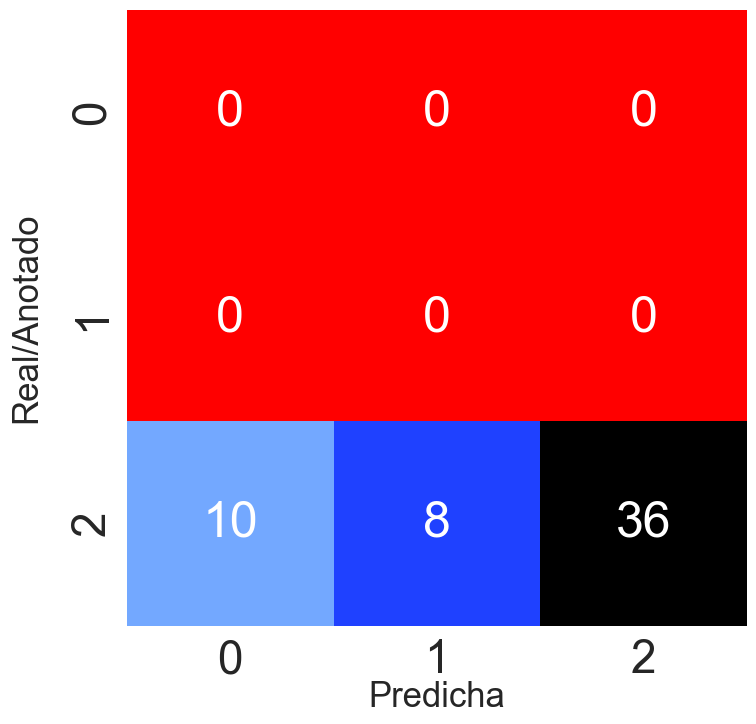

In [19]:
# Función para clasificar partículas y evaluar el resultado
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

def preprocess_and_segment(img):
    # Aplicar un filtro de mediana
    img_blur = cv2.GaussianBlur(img, (5,5), 0)

    # Aplicar umbralización adaptativa
    _, thresh = cv2.threshold(img_blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    """"
    # Mostrar la imagen umbralizada usando matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(thresh, cmap='gray')  # Muestra la imagen en escala de grises
    plt.title(f'Umbralizado de {image_path}')
    plt.axis('off')  # Desactiva los ejes
    plt.show()
    
    -----
    # Visualizar contornos
        for contour in contours:
        cv2.drawContours(img_mod, [contour], -1, (255, 0, 0), 2)  # Dibuja contornos en rojo   
    plt.imshow(img_mod, cmap='gray')
    plt.title('Contornos detectados')
    plt.show()
    """

    # Extraer los contornos
    contours, _= cv2.findContours(thresh, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)

    # Filtrar contornos por área para eliminar ruido
    contours = [c for c in contours if cv2.contourArea(c) > 100]  # Ajusta este valor según tus datos
    
    return contours


def extract_features(contour, img_color):
    features = {}
    
    # Calcular características geométricas clave
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    compactness = (perimeter ** 2) / area if area > 0 else 0

    # Usar boundingRect para calcular el aspect ratio
    _, __, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h if h > 0 else 0

    # Calcular el color medio de la partícula usando el contorno
    mask = np.zeros(img_color.shape[:2], dtype=np.uint8)  # Crear una máscara en blanco
    cv2.drawContours(mask, [contour], -1, 255, -1)  # Dibujar el contorno en la máscara
    mean_color = cv2.mean(img_color, mask=mask)  # Obtener el color medio (BGR)
    
    isBlack = 1 if ((mean_color[0] + mean_color[1] + mean_color[2]) // 3) <= 30 else 0 
    # Guardar las características clave, incluyendo el color medio
    features['area'] = area
    features['perimeter'] = perimeter
    features['compactness'] = compactness
    features['aspect_ratio'] = aspect_ratio
    features['mean_color_B'] = isBlack

    # Retornar todas las características como un array plano
    return list(features.values())



# Función para clasificar partículas y evaluar el resultado
def classify_and_evaluate(X_train, y_train, X_test, y_test):
    # Usar imputer para manejar valores NaN
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Crear y entrenar el modelo SVM
    model = SVC()
    model.fit(X_train, y_train)

    # Hacer predicciones
    y_pred = model.predict(X_test)

    # Mostrar el número de partículas clasificadas en cada clase
    unique, counts = np.unique(y_pred, return_counts=True)

    # Evaluar el rendimiento del modelo usando las métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1score = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1score:.2f}")

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,8))
    sns.set(font_scale = 1.75)#tamaños tipografía
    sns.set(font_scale = 3.0)

    ax = sns.heatmap(
            conf_matrix, # confusion matrix 2D array 
            annot=True, # Muestra números en las celdas
            fmt='d', # valores enteros
            cbar=False, # sin barra de colores
            cmap='flag', # mapa de colores
            #vmax=175 # contraste de color
        )

    #Etiquetas matriz de confusión
    label_font = {'size':'25'}
    ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
    ax.set_ylabel("Real/Anotado", labelpad=20, fontdict=label_font)
    
    #print("Matriz de confusión:")
    #print(conf_matrix)
    print("------------------------------------------")
    
# Zona entrenamiento
image_paths_train = ["FRA.png", "PEL.png", "TAR.png"]
labels_train = [1, 2, 3]
X_train = []
y_train = []

for img_path, label in zip(image_paths_train, labels_train):
    # Leer la imagen en escala de grises
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    contours = preprocess_and_segment(img)
    for contour in contours:
        features = extract_features(contour, img)
        if not any(np.isnan(features)) and not any(np.isinf(features)):
            X_train.append(features)
            y_train.append(label)

# Zona test
# Procesar la imagen de prueba
image_paths_test = ["uno.JPG", "dos.JPG", "tres.JPG"]
X_test = []
X_tests = []
y_test = [[1] * 80, [2] * 54, [3] * 54]
contador = 0

# Enmascarar la imagen, hacer un AND con la imagen original suma de los valores en promedio con el área y calculo color, si no es oscuro no es 3
# Extraer características geométricas de la imagen de prueba
for index in range(len(image_paths_test)):
    # Leer la imagen en escala de grises
    img = cv2.imread(image_paths_test[index], cv2.IMREAD_GRAYSCALE)
    
    # Obtener el tamaño de la imagen
    height, width = img.shape   
    y1, y2, x1, x2 = int(0.05 * height), int(0.80 * height), int(0.15 * width), int(0.95 * width)
    
    # Imagen recortada
    img_mod = img[y1:y2, x1:x2]
    contours = preprocess_and_segment(img_mod)
    
    for contour in contours:
        # print(f'Contorno = {contour}')
        features = extract_features(contour, img)
        contador += 1
        if not any(np.isnan(list(features))) and not any(np.isinf(list(features))) and len(X_test) < len(y_test[index]): X_test.append(features)
    
    X_tests.append(X_test)
    X_test = []
    
    if len(X_tests[index]) == 0:
        print("No se encontraron partículas en la imagen de prueba.")
    else:
        # Clasificar las partículas y evaluar el modelo
        classify_and_evaluate(X_train, y_train, X_tests[index], y_test[index])
